## **0. Import libraries**

In [ ]:
import torch
import random
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

## **1. Prepare dataset**


In [ ]:
batch_size = 512

train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.3MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.31MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.12MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network**




In [ ]:
class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        return x


class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

In [ ]:
first = MLP_2layers(input_dims=784, output_dims=128)
second = MLP_2layers(input_dims=128, output_dims=128)
third = MLP_2layers(input_dims=128, output_dims=128)
fourth = MLP_1layer(input_dims=128, output_dims=128)

lr = 1e-2
criterion = nn.CrossEntropyLoss()

## **3. Training 1**

In [ ]:
model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3077, Train_Acc: 0.1206, Validation Loss: 1.3809, Val_Acc: 0.1167
EPOCH 2/100, Train_Loss: 2.3001, Train_Acc: 0.1249, Validation Loss: 1.3793, Val_Acc: 0.1375
EPOCH 3/100, Train_Loss: 2.2973, Train_Acc: 0.1711, Validation Loss: 1.3777, Val_Acc: 0.1715
EPOCH 4/100, Train_Loss: 2.2945, Train_Acc: 0.2014, Validation Loss: 1.3760, Val_Acc: 0.1405
EPOCH 5/100, Train_Loss: 2.2915, Train_Acc: 0.2186, Validation Loss: 1.3739, Val_Acc: 0.2873
EPOCH 6/100, Train_Loss: 2.2884, Train_Acc: 0.2754, Validation Loss: 1.3722, Val_Acc: 0.2692
EPOCH 7/100, Train_Loss: 2.2850, Train_Acc: 0.2711, Validation Loss: 1.3698, Val_Acc: 0.4283
EPOCH 8/100, Train_Loss: 2.2813, Train_Acc: 0.3501, Validation Loss: 1.3680, Val_Acc: 0.2873
EPOCH 9/100, Train_Loss: 2.2774, Train_Acc: 0.3453, Validation Loss: 1.3652, Val_Acc: 0.4052
EPOCH 10/100, Train_Loss: 2.2730, Train_Acc: 0.3496, Validation Loss: 1.3624, Val_Acc: 0.3010
EPOCH 11/100, Train_Loss: 2.2680, Train_Acc: 0.3796, Validation Loss:

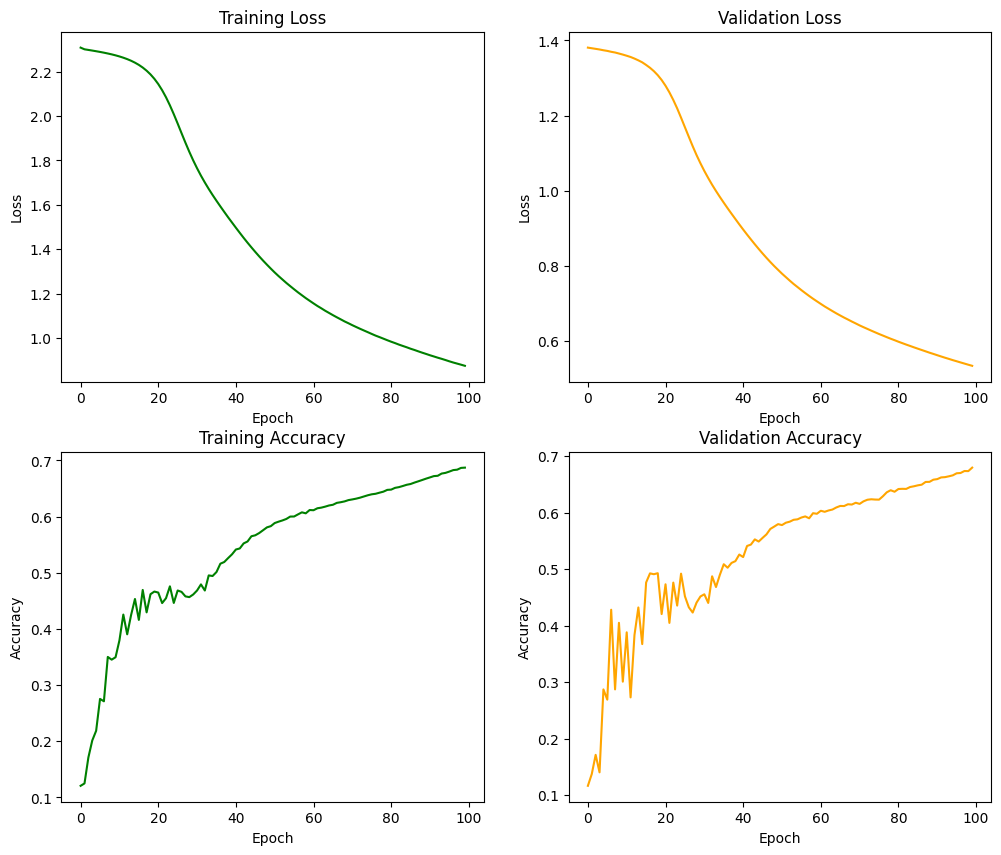

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **4. Training 2**

In [ ]:
for param in first.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(),
                      lr=lr)


In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3049, Train_Acc: 0.0988, Validation Loss: 1.3816, Val_Acc: 0.1020
EPOCH 2/100, Train_Loss: 2.3022, Train_Acc: 0.1090, Validation Loss: 1.3813, Val_Acc: 0.0937
EPOCH 3/100, Train_Loss: 2.3017, Train_Acc: 0.1090, Validation Loss: 1.3811, Val_Acc: 0.0997
EPOCH 4/100, Train_Loss: 2.3012, Train_Acc: 0.1179, Validation Loss: 1.3805, Val_Acc: 0.1020
EPOCH 5/100, Train_Loss: 2.3007, Train_Acc: 0.1252, Validation Loss: 1.3805, Val_Acc: 0.0895
EPOCH 6/100, Train_Loss: 2.3002, Train_Acc: 0.1244, Validation Loss: 1.3800, Val_Acc: 0.1018
EPOCH 7/100, Train_Loss: 2.2996, Train_Acc: 0.1324, Validation Loss: 1.3797, Val_Acc: 0.1000
EPOCH 8/100, Train_Loss: 2.2990, Train_Acc: 0.1246, Validation Loss: 1.3795, Val_Acc: 0.0895
EPOCH 9/100, Train_Loss: 2.2985, Train_Acc: 0.1779, Validation Loss: 1.3794, Val_Acc: 0.2447
EPOCH 10/100, Train_Loss: 2.2980, Train_Acc: 0.1576, Validation Loss: 1.3786, Val_Acc: 0.2010
EPOCH 11/100, Train_Loss: 2.2973, Train_Acc: 0.1790, Validation Loss:

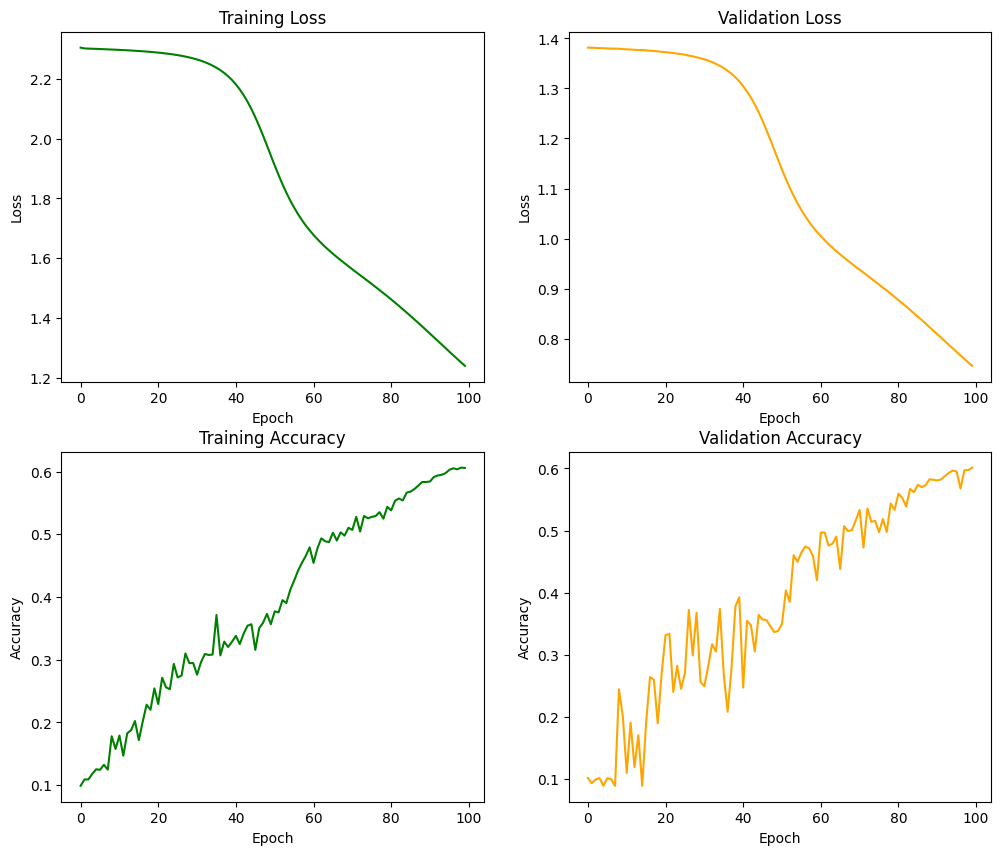

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **5. Training 3**

In [ ]:
for param in first.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(),
                      lr=lr)

# train()

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.1612, Train_Acc: 0.2317, Validation Loss: 1.2203, Val_Acc: 0.2118
EPOCH 2/100, Train_Loss: 1.9471, Train_Acc: 0.3470, Validation Loss: 1.1257, Val_Acc: 0.3602
EPOCH 3/100, Train_Loss: 1.8203, Train_Acc: 0.4144, Validation Loss: 1.0660, Val_Acc: 0.4477
EPOCH 4/100, Train_Loss: 1.7360, Train_Acc: 0.4597, Validation Loss: 1.0238, Val_Acc: 0.4400
EPOCH 5/100, Train_Loss: 1.6744, Train_Acc: 0.4746, Validation Loss: 0.9914, Val_Acc: 0.4663
EPOCH 6/100, Train_Loss: 1.6255, Train_Acc: 0.4902, Validation Loss: 0.9653, Val_Acc: 0.4910
EPOCH 7/100, Train_Loss: 1.5845, Train_Acc: 0.5105, Validation Loss: 0.9425, Val_Acc: 0.5022
EPOCH 8/100, Train_Loss: 1.5486, Train_Acc: 0.5213, Validation Loss: 0.9223, Val_Acc: 0.5213
EPOCH 9/100, Train_Loss: 1.5159, Train_Acc: 0.5300, Validation Loss: 0.9042, Val_Acc: 0.5310
EPOCH 10/100, Train_Loss: 1.4859, Train_Acc: 0.5396, Validation Loss: 0.8868, Val_Acc: 0.5378
EPOCH 11/100, Train_Loss: 1.4579, Train_Acc: 0.5474, Validation Loss:

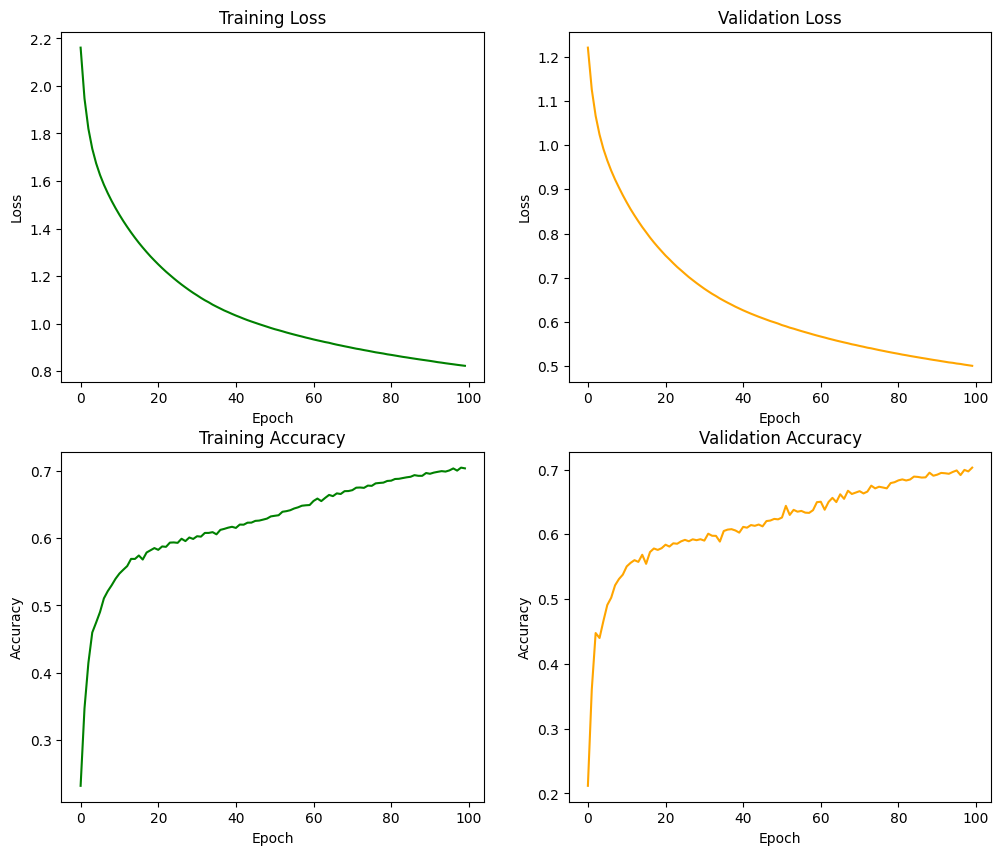

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **6. Training 4**

In [ ]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3060, Train_Acc: 0.1098, Validation Loss: 1.3809, Val_Acc: 0.0895
EPOCH 2/100, Train_Loss: 2.3006, Train_Acc: 0.1246, Validation Loss: 1.3803, Val_Acc: 0.0997
EPOCH 3/100, Train_Loss: 2.2998, Train_Acc: 0.1493, Validation Loss: 1.3796, Val_Acc: 0.2275
EPOCH 4/100, Train_Loss: 2.2990, Train_Acc: 0.1744, Validation Loss: 1.3793, Val_Acc: 0.1887
EPOCH 5/100, Train_Loss: 2.2981, Train_Acc: 0.1480, Validation Loss: 1.3788, Val_Acc: 0.0963
EPOCH 6/100, Train_Loss: 2.2972, Train_Acc: 0.1638, Validation Loss: 1.3780, Val_Acc: 0.3292
EPOCH 7/100, Train_Loss: 2.2963, Train_Acc: 0.1878, Validation Loss: 1.3776, Val_Acc: 0.2210
EPOCH 8/100, Train_Loss: 2.2953, Train_Acc: 0.2027, Validation Loss: 1.3771, Val_Acc: 0.1565
EPOCH 9/100, Train_Loss: 2.2942, Train_Acc: 0.2224, Validation Loss: 1.3762, Val_Acc: 0.1817
EPOCH 10/100, Train_Loss: 2.2931, Train_Acc: 0.2309, Validation Loss: 1.3756, Val_Acc: 0.3145
EPOCH 11/100, Train_Loss: 2.2918, Train_Acc: 0.2176, Validation Loss:

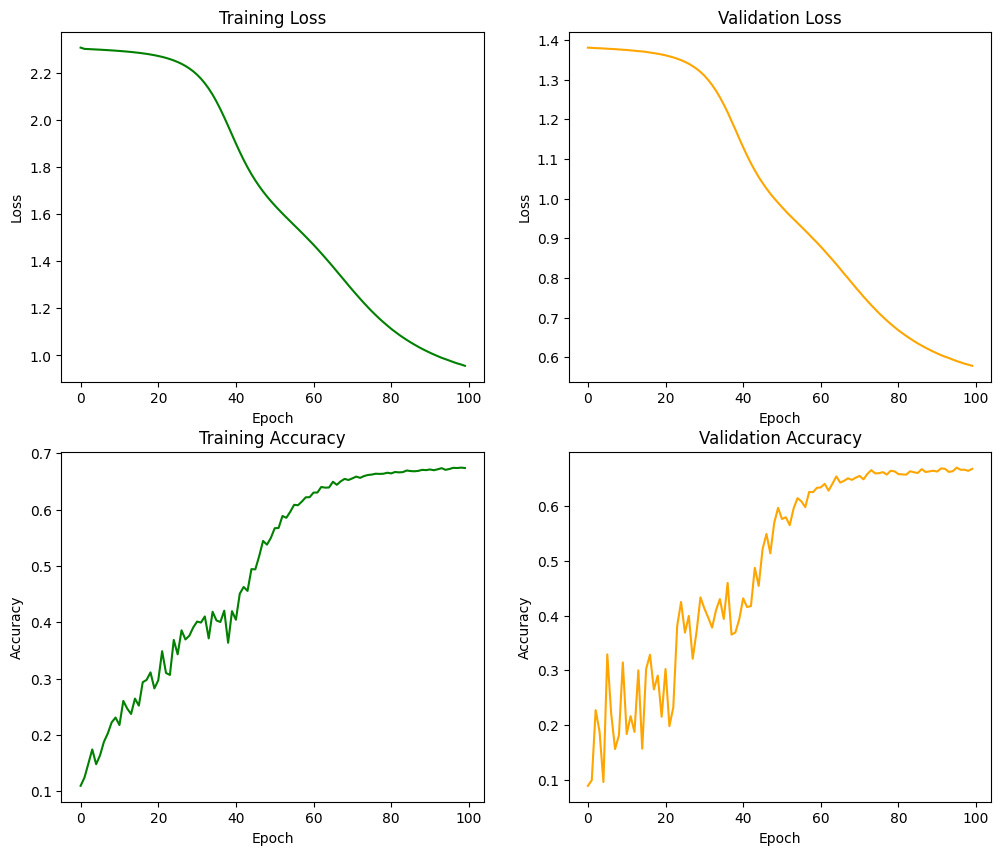

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **7. Training 5**


In [ ]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.0995, Train_Acc: 0.3230, Validation Loss: 1.1631, Val_Acc: 0.4605
EPOCH 2/100, Train_Loss: 1.8278, Train_Acc: 0.5031, Validation Loss: 1.0420, Val_Acc: 0.5080
EPOCH 3/100, Train_Loss: 1.6633, Train_Acc: 0.5276, Validation Loss: 0.9631, Val_Acc: 0.5485
EPOCH 4/100, Train_Loss: 1.5514, Train_Acc: 0.5381, Validation Loss: 0.9069, Val_Acc: 0.5488
EPOCH 5/100, Train_Loss: 1.4692, Train_Acc: 0.5535, Validation Loss: 0.8640, Val_Acc: 0.5607
EPOCH 6/100, Train_Loss: 1.4047, Train_Acc: 0.5630, Validation Loss: 0.8299, Val_Acc: 0.5580
EPOCH 7/100, Train_Loss: 1.3532, Train_Acc: 0.5651, Validation Loss: 0.8021, Val_Acc: 0.5733
EPOCH 8/100, Train_Loss: 1.3105, Train_Acc: 0.5745, Validation Loss: 0.7793, Val_Acc: 0.5777
EPOCH 9/100, Train_Loss: 1.2748, Train_Acc: 0.5837, Validation Loss: 0.7596, Val_Acc: 0.5702
EPOCH 10/100, Train_Loss: 1.2441, Train_Acc: 0.5831, Validation Loss: 0.7429, Val_Acc: 0.5973
EPOCH 11/100, Train_Loss: 1.2175, Train_Acc: 0.5926, Validation Loss:

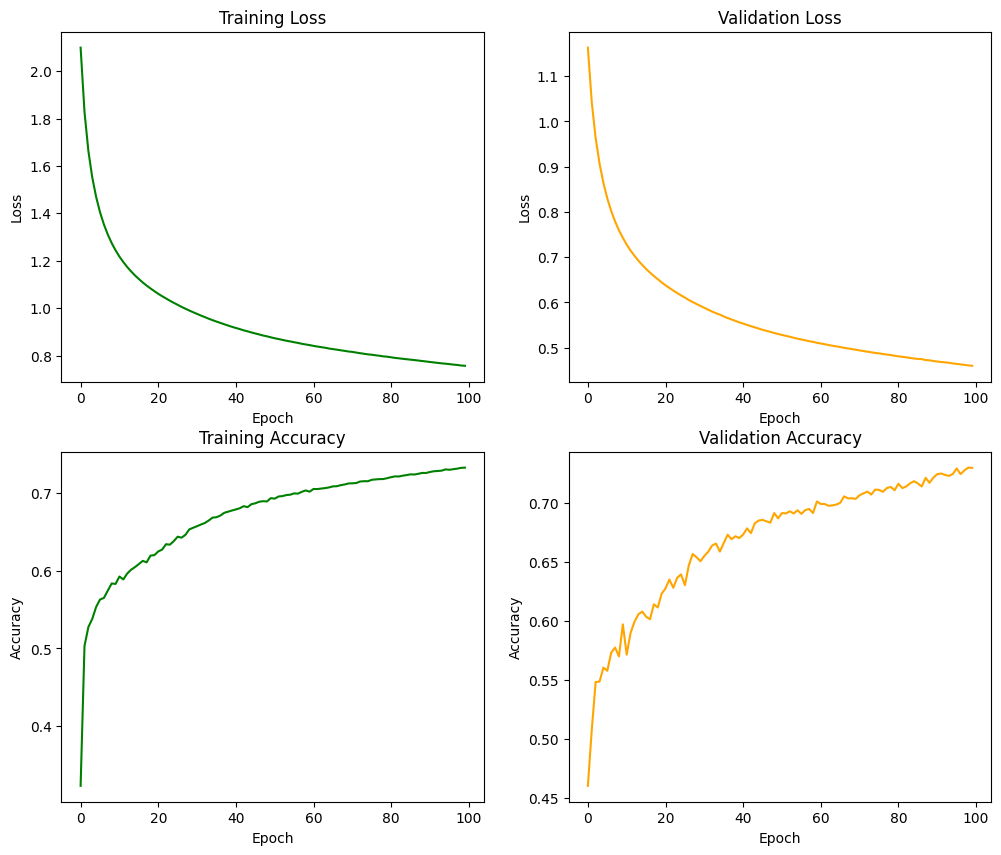

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **8. Training 6**


In [ ]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False
for param in third.parameters():
    param.requires_grad = False

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.2996, Train_Acc: 0.1131, Validation Loss: 1.3671, Val_Acc: 0.2093
EPOCH 2/100, Train_Loss: 2.2644, Train_Acc: 0.2821, Validation Loss: 1.3501, Val_Acc: 0.3637
EPOCH 3/100, Train_Loss: 2.2334, Train_Acc: 0.3740, Validation Loss: 1.3300, Val_Acc: 0.4017
EPOCH 4/100, Train_Loss: 2.1973, Train_Acc: 0.4462, Validation Loss: 1.3069, Val_Acc: 0.4590
EPOCH 5/100, Train_Loss: 2.1541, Train_Acc: 0.4665, Validation Loss: 1.2784, Val_Acc: 0.4085
EPOCH 6/100, Train_Loss: 2.1026, Train_Acc: 0.4789, Validation Loss: 1.2449, Val_Acc: 0.5125
EPOCH 7/100, Train_Loss: 2.0422, Train_Acc: 0.5086, Validation Loss: 1.2063, Val_Acc: 0.5415
EPOCH 8/100, Train_Loss: 1.9745, Train_Acc: 0.5416, Validation Loss: 1.1639, Val_Acc: 0.5467
EPOCH 9/100, Train_Loss: 1.9017, Train_Acc: 0.5441, Validation Loss: 1.1199, Val_Acc: 0.5683
EPOCH 10/100, Train_Loss: 1.8272, Train_Acc: 0.5633, Validation Loss: 1.0755, Val_Acc: 0.5762
EPOCH 11/100, Train_Loss: 1.7541, Train_Acc: 0.5723, Validation Loss:

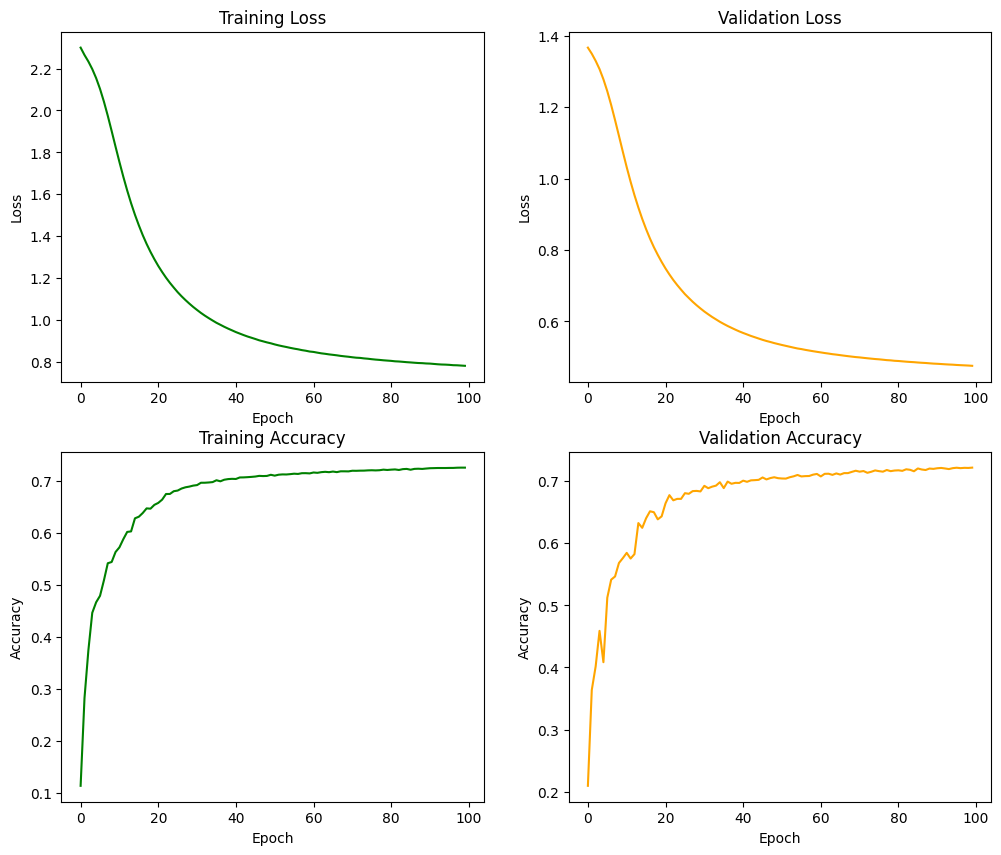

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **9. Training 7**


In [ ]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True
for param in third.parameters():
    param.requires_grad = True

model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.0577, Train_Acc: 0.3766, Validation Loss: 1.1006, Val_Acc: 0.5203
EPOCH 2/100, Train_Loss: 1.6939, Train_Acc: 0.5505, Validation Loss: 0.9507, Val_Acc: 0.5683
EPOCH 3/100, Train_Loss: 1.5004, Train_Acc: 0.5691, Validation Loss: 0.8616, Val_Acc: 0.5690
EPOCH 4/100, Train_Loss: 1.3792, Train_Acc: 0.5941, Validation Loss: 0.8027, Val_Acc: 0.6093
EPOCH 5/100, Train_Loss: 1.2960, Train_Acc: 0.6155, Validation Loss: 0.7607, Val_Acc: 0.6188
EPOCH 6/100, Train_Loss: 1.2350, Train_Acc: 0.6243, Validation Loss: 0.7286, Val_Acc: 0.6353
EPOCH 7/100, Train_Loss: 1.1876, Train_Acc: 0.6296, Validation Loss: 0.7039, Val_Acc: 0.6195
EPOCH 8/100, Train_Loss: 1.1493, Train_Acc: 0.6365, Validation Loss: 0.6833, Val_Acc: 0.6345
EPOCH 9/100, Train_Loss: 1.1177, Train_Acc: 0.6425, Validation Loss: 0.6660, Val_Acc: 0.6417
EPOCH 10/100, Train_Loss: 1.0912, Train_Acc: 0.6491, Validation Loss: 0.6513, Val_Acc: 0.6478
EPOCH 11/100, Train_Loss: 1.0678, Train_Acc: 0.6549, Validation Loss:

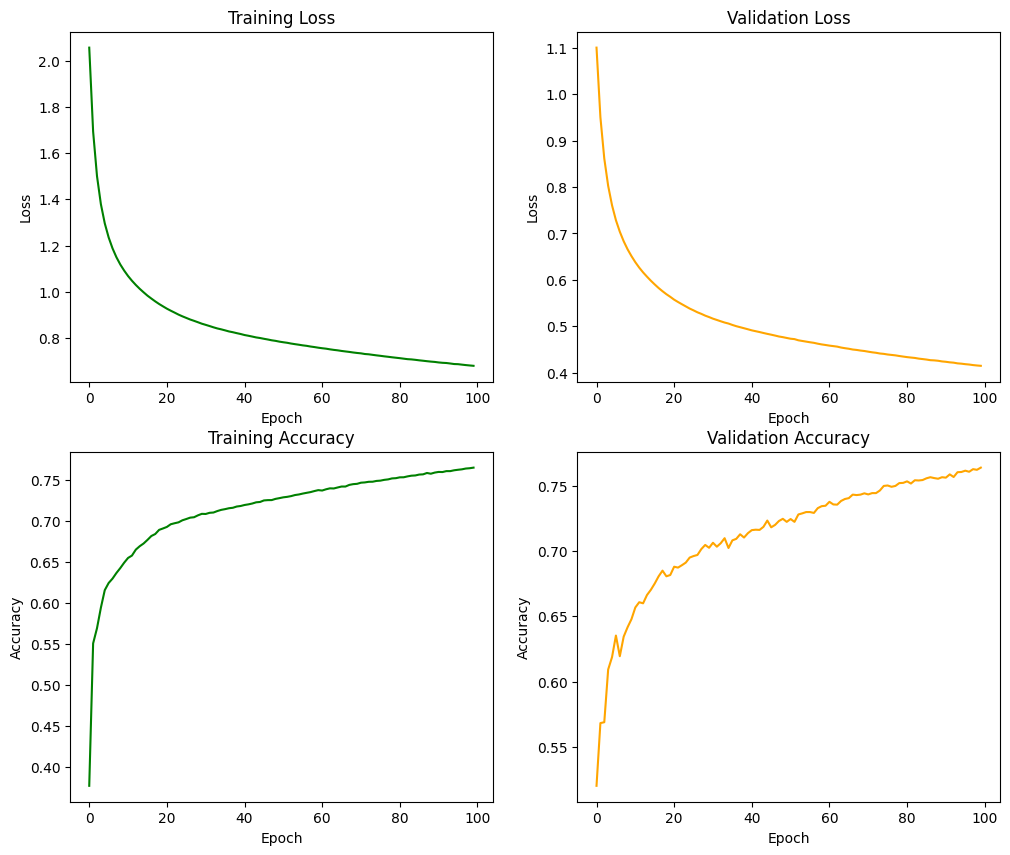

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **10. Evaluation**

In [ ]:
val_target = []
val_predict = []

model.eval()
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        outputs = model(X_val)

        val_predict.append(outputs.cpu())
        val_target.append(y_val.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = (torch.argmax(val_predict, 1) == val_target).sum().item() / len(val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.7638333333333334


In [ ]:
test_target = []
test_predict = []

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)

        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.7614
